In [1]:
library(cowplot)
library(magrittr)
library(ggrepel)
library(igraph)
library(tidyverse)
library(tidygraph)
library(ggnetwork)
suppressWarnings(suppressMessages(library(network)))
suppressWarnings(suppressMessages(library(sna)))

theme_set(theme_cowplot())
results <- '../results/'
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweenness = centrality_betweenness(),
           degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod')


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: ggplot2

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       mas

In [2]:
# from DisGeNET
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene
g_known <- activate(ppi, nodes) %>%
    filter(name %in% known_brca_genes) %>%
    mutate(known = TRUE)
class(g_known) <- c('igraph','tbl_graph')

# Subnetworks

## LEAN

In [3]:
lean_p <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd')
lean <- lean_p$Gene[lean_p$PLEAN < 0.05]
g_lean <- activate(ppi, nodes) %>%
    filter(name %in% lean)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

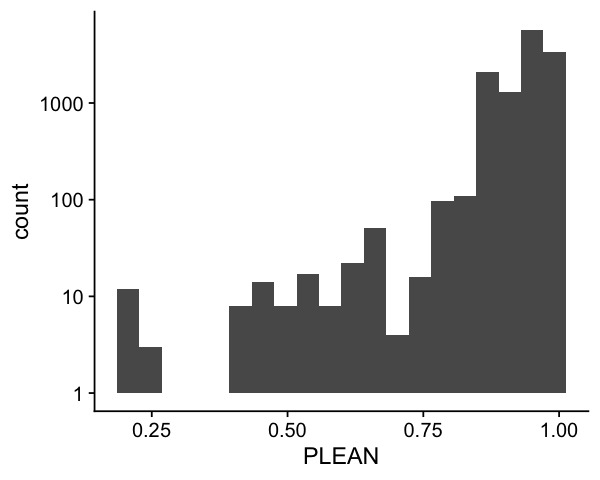

In [4]:
options(repr.plot.width=5, repr.plot.height=4)
ggplot(lean_p, aes(PLEAN)) +
    geom_histogram(bins = 20) +
    scale_y_log10()

## Sigmod

In [5]:
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
g_sigmod <- activate(ppi, nodes) %>%
    filter(name %in% sigmod) %>%
    mutate(sigmod = TRUE)
class(g_sigmod) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown aesthetics: xend, yend”

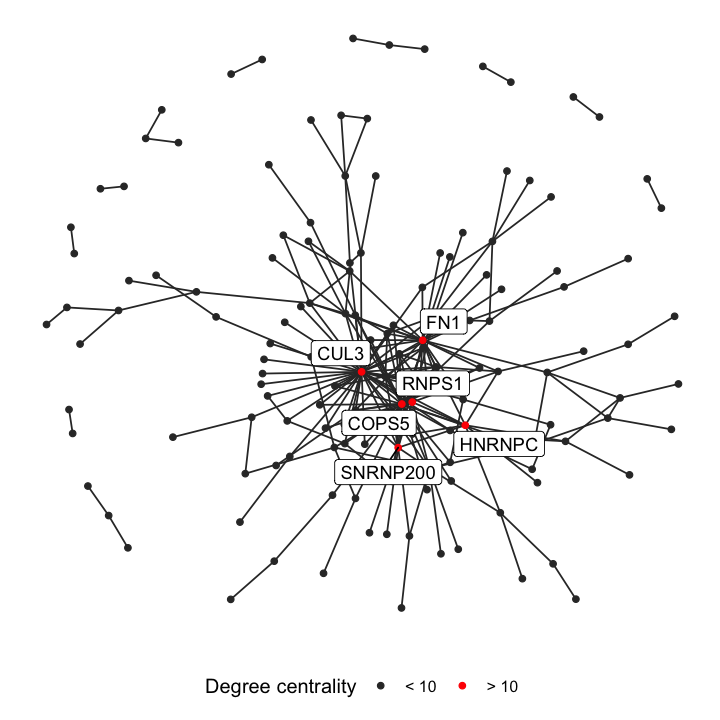

In [6]:
plt_df <- g_sigmod %>%
    mutate(d = centrality_degree()) %>%
    ggnetwork %>%
    mutate(vertex.names = as.character(vertex.names))

options(repr.plot.width=6, repr.plot.height=6)
ggplot() +
    geom_edges(data = plt_df, aes(x = x, y = y, xend = xend, yend = yend), color = 'gray20') +
    geom_nodes(data = plt_df, aes(x = x, y = y, xend = xend, yend = yend, color = ifelse(d > 10, '> 10', '< 10'))) +
    geom_label_repel(data = filter(plt_df, d > 10 & x == xend & y == yend) %>% select(x, y, vertex.names) %>% unique,
                     aes(x = x, y = y, label = vertex.names)) +
    theme_blank() +
    theme(legend.position = 'bottom') +
    labs(color = 'Degree centrality', size = bquote('-log' [10] ~'(P-value)')) +
    scale_color_manual(values = c('< 10' = 'gray20', '> 10' = 'red'))

## dmGWAS

In [7]:
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene

In [8]:
g_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas) %>%
    mutate(dmgwas = TRUE)
class(g_dmgwas) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”

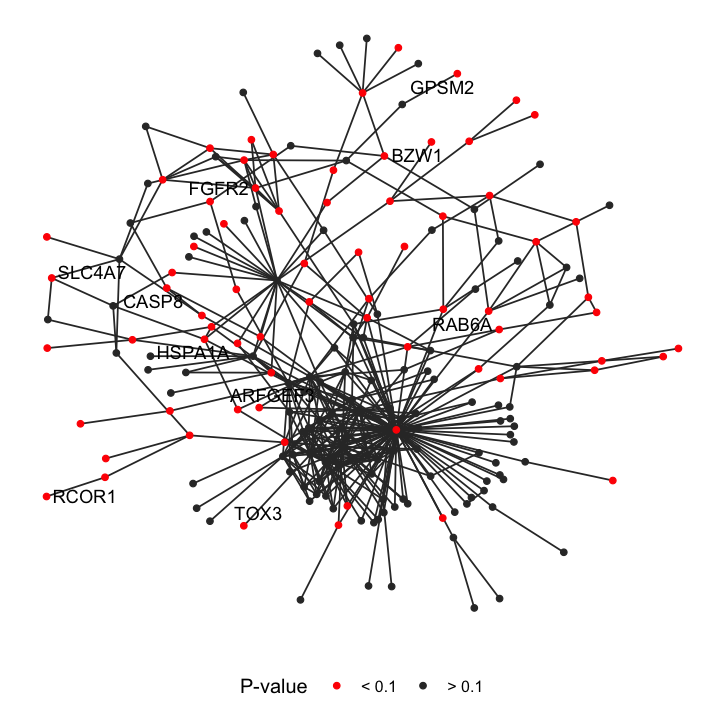

In [9]:
options(repr.plot.width=6, repr.plot.height=6)
g_dmgwas %>%
    ggnetwork %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(color = ifelse(p > 0.1, '> 0.1', '< 0.1'))) +
        geom_nodetext_repel(aes(label = ifelse(p < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(color = 'P-value', size = bquote('-log' [10] ~'(P-value)')) +
        scale_color_manual(values = c('> 0.1' = 'gray20', '< 0.1' = 'red'))

## Heinz

In [10]:
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene

In [11]:
g_heinz <- activate(ppi, nodes) %>%
    filter(name %in% heinz) %>%
    mutate(heinz = TRUE)
class(g_heinz) <- c('igraph','tbl_graph')

## SConES

In [12]:
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique

g_scones_gs <- activate(ppi, nodes) %>%
    filter(name %in% scones_gs) %>%
    mutate(scones_gs = TRUE)
class(g_scones_gs) <- c('igraph','tbl_graph')

g_scones_gm <- activate(ppi, nodes) %>%
    filter(name %in% scones_gm) %>%
    mutate(scones_gm = TRUE)
class(g_scones_gm) <- c('igraph','tbl_graph')

g_scones_gi <- activate(ppi, nodes) %>%
    filter(name %in% scones_gi) %>%
    mutate(scones_gi = TRUE)
class(g_scones_gi) <- c('igraph','tbl_graph')

[1] "NEK10"          "MICOS10P3"      "RNU6-342P"      "SLC4A7"        
 [5] "RPS20P15"       "RNU1-96P"       "FGF10"          "FGF10-AS1"     
 [9] "LINC02224"      "RN7SL383P"      "MRPS30-DT"      "MRPS30"        
[13] "RNU6-271P"      "ZNF518A"        "NPM1P25"        "BLNK"          
[17] "OPALIN"         "DNTT"           "TLL2"           "TM9SF3"        
[21] "RNA5SP324"      "RPS2P36"        "PIK3AP1"        "RNU6-1274P"    
[25] "RPL13AP5"       "MIR607"         "LCOR"           "HMGN2P35"      
[29] "SLIT1"          "SLIT1-AS1"      "ARHGAP19-SLIT1" "ARHGAP19"      
[33] "RPL12P27"       "FRAT1"          "FRAT2"          "RRP12"         
[37] "RPL34P20"       "PGAM1"          "EXOSC1"         "ZDHHC16"       
[41] "MMS19"          "UBTD1"          "ANKRD2"         "HOGA1"         
[45] "C10orf62"       "MORN4"          "PI4K2A"         "AVPI1"         
[49] "MARVELD1"       "ZFYVE27"        "SFRP5"          "LINC00866"     
[53] "GOLGA7B"        "CRTAC1"         "RN7SKP167"      "FGFR2"         
[57] "TOX3"           "CASC16"

# Consensus subnetwork

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”

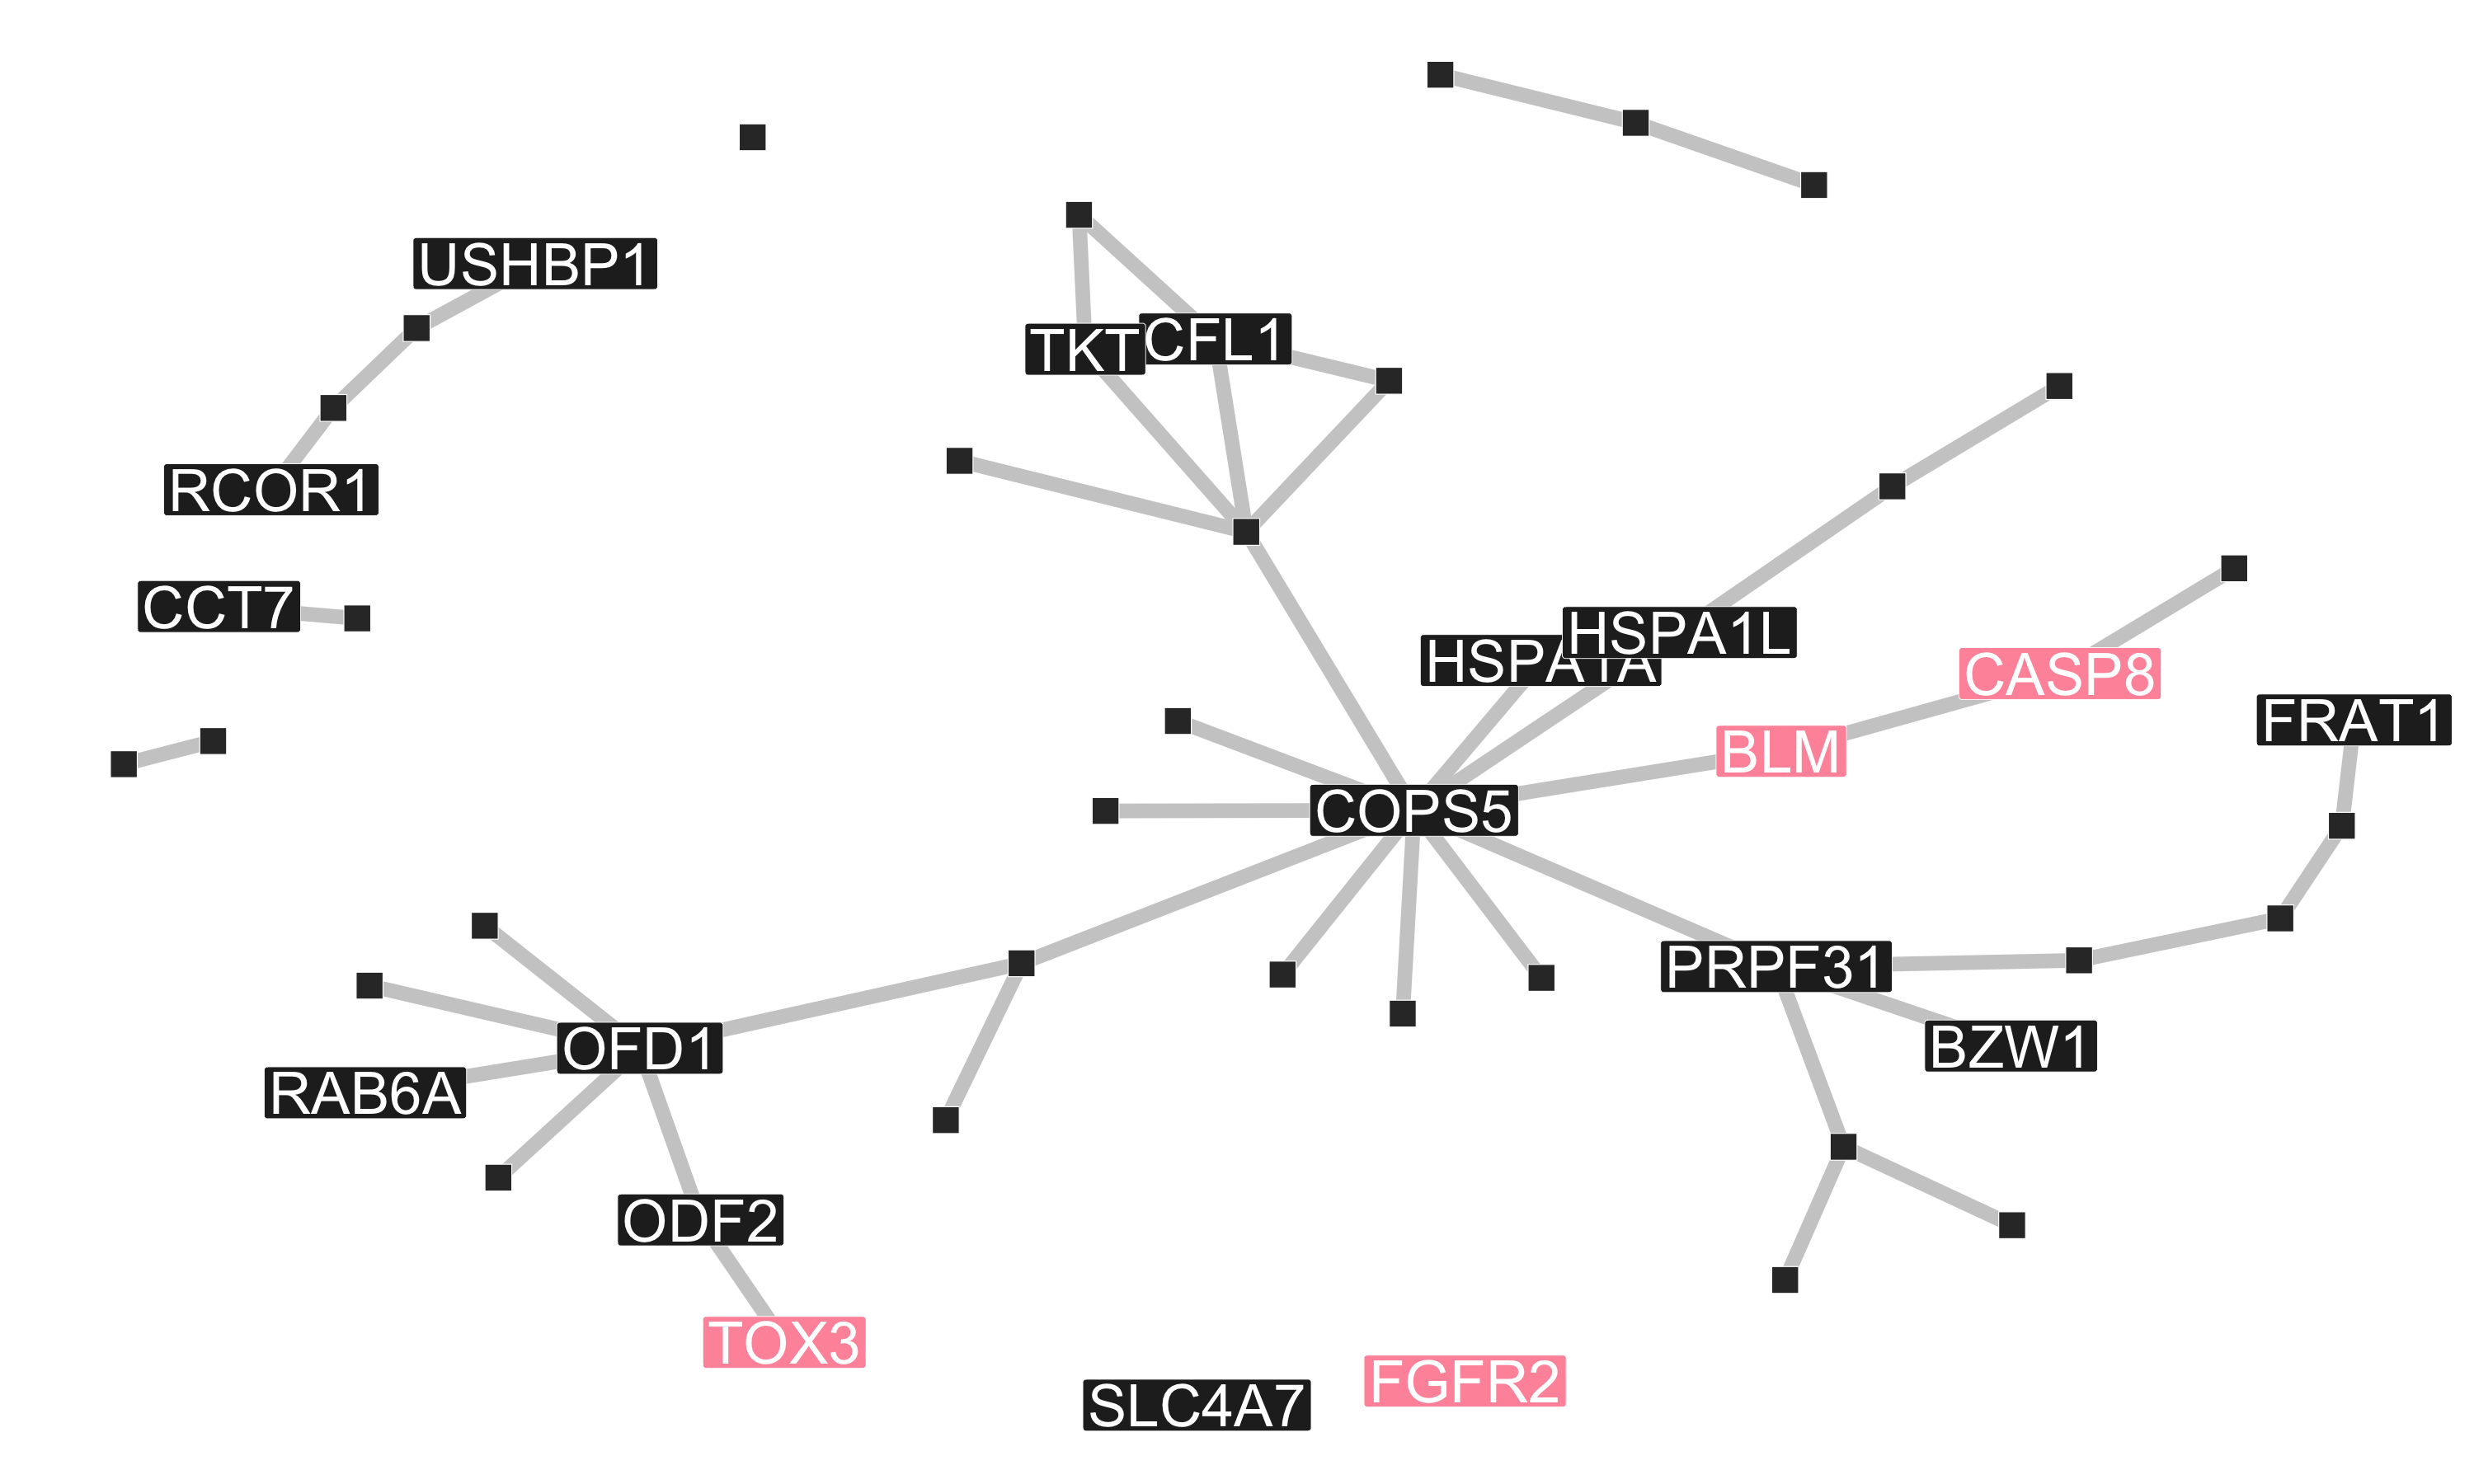

In [13]:
options(repr.plot.width=25, repr.plot.height=15)
consensus <- graph_join(g_sigmod, g_dmgwas, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_heinz, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_scones_gm, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_known, by = c('name','betweenness','degree','p')) %>%
    to_undirected %>%
    mutate(dmgwas = ifelse(is.na(dmgwas), FALSE, dmgwas),
           heinz = ifelse(is.na(heinz), FALSE, heinz),
           scones_gm = ifelse(is.na(scones_gm), FALSE, scones_gm),
           sigmod = ifelse(is.na(sigmod), FALSE, sigmod),
           known = ifelse(is.na(known), FALSE, known),
           num_methods = rowSums(cbind(dmgwas, sigmod, heinz, scones_gm))) %>%
    filter(num_methods > 1)

as.tibble(consensus) %>%
    rename(gene = name) %>%
    write_tsv(paste0(results,'consensus/consensus.tsv'))

consensus_gg <- consensus %>%
    ggnetwork

highlight <- consensus_gg$num_methods == 3 | 
             consensus_gg$p < 0.001 | 
             consensus_gg$degree > 100 |
             consensus_gg$known

ggplot() +
    geom_edges(data = consensus_gg, aes(x = x, y = y, xend = xend, yend = yend), 
               size = 5, color = 'grey80') +
    geom_nodes(data = filter(consensus_gg, !highlight), 
               aes(x = x, y = y), size = 10, fill = 'gray20', color = 'white', shape = 22) +
    geom_nodelabel(data = filter(consensus_gg, highlight), 
                   aes(x = x, y = y, label = vertex.names, fill = known), 
                   size = 15, color = 'white') +
    theme_blank() +
    labs(size = '# methods') +
    scale_size_manual(values = c('2' = 6, '3' = 10)) +
    scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
    theme(text = element_text(size = 40), legend.position = 'none')

# Heterogeneity study

Warning message:
“Removed 1 rows containing missing values (geom_text).”

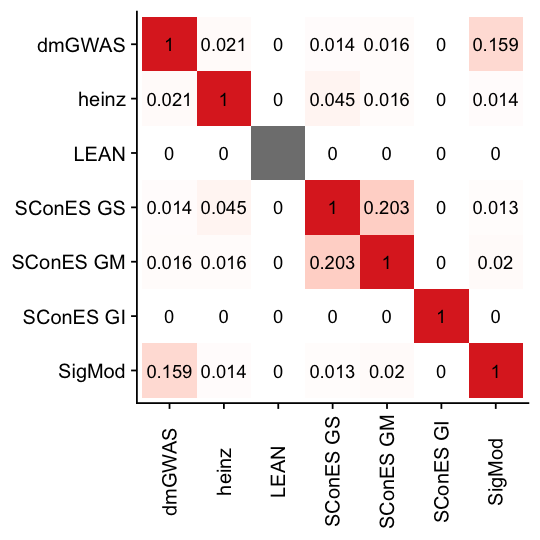

In [14]:
bms <- list(dmgwas, heinz, lean, scones_gs, scones_gm, scones_gi, sigmod)

options(repr.plot.width=4.5, repr.plot.height=4.5)
lapply(bms, function(x) 
       lapply(bms, function(x,y) 
           length(intersect(x,y))/length(union(x,y)), x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, jaccard, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           jaccard = round(as.numeric(jaccard), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = jaccard, label = jaccard)) +
        geom_tile() +
        geom_text() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 90, vjust = 0.5))

In [15]:
method_summary <- function(graph) {
    
    consensus_nodes <- names(V(consensus))
    method_nodes <- names(V(graph))
    j <- length(intersect(consensus_nodes,method_nodes))/length(union(consensus_nodes,method_nodes))
    
    tibble(`# nodes` = length(V(graph)),
           `# edges` = length(E(graph)),
           `Median betweenness` = mean(as.tibble(graph) %>% .$betweenness, na.rm = T) %>% format(digits = 2),
           `Median gene P-value` = median(as.tibble(graph) %>% .$p, na.rm = T) %>% format(digits = 2),
           `Jaccard consensus` =  format(j, digits = 2))
    
}

In [16]:
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

bind_rows(mutate(method_summary(ppi), Method = 'HINT'),
          mutate(method_summary(consensus), Method = 'Consensus'),
          mutate(method_summary(g_dmgwas), Method = 'dmGWAS'),
          mutate(method_summary(g_heinz), Method = 'heinz'),
          mutate(method_summary(g_lean), Method = 'LEAN'),
          mutate(method_summary(g_scones_gs), Method = 'SConES GS'),
          mutate(method_summary(g_scones_gm), Method = 'SConES GM'),
          mutate(method_summary(g_scones_gi), Method = 'SConES GI'),
          mutate(method_summary(g_sigmod), Method = 'SigMod')) %>%
    select(Method, everything())

Method,# nodes,# edges,Median betweenness,Median gene P-value,Jaccard consensus
<chr>,<int>,<int>,<chr>,<chr>,<chr>
HINT,13619,142541,16706,0.46,0.0037
Consensus,51,110,78426,0.0047,1
dmGWAS,194,450,49115,0.19,0.25
heinz,4,3,113633,0.0012,0.078
LEAN,0,0,NaN,NA,0
SConES GS,5,0,9805,2.7e-05,0.077
SConES GM,28,2,4267,0.067,0.082
SConES GI,0,0,NaN,NA,0
SigMod,142,249,92603,0.0083,0.33


# Consensus genes

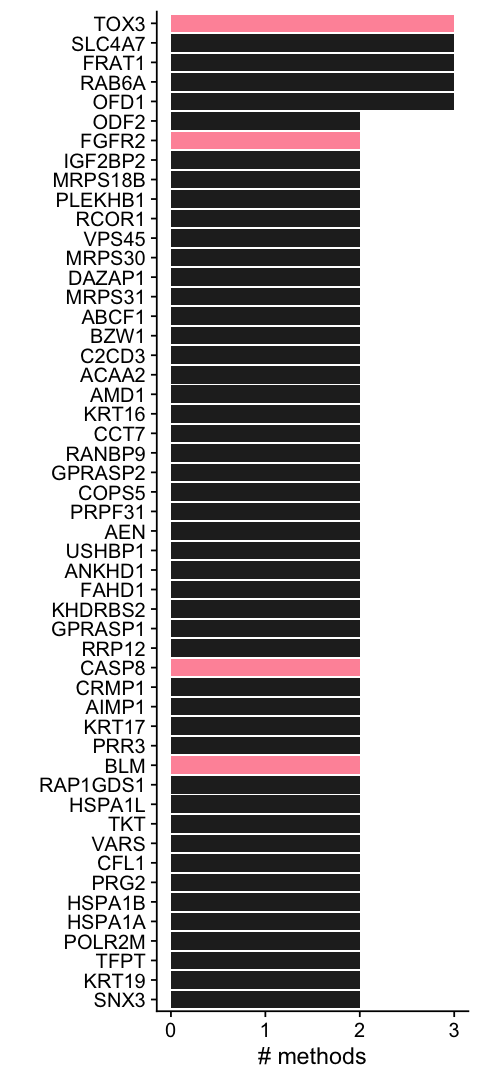

In [17]:
options(repr.plot.width=4, repr.plot.height=9)
as.tibble(consensus) %>%
    arrange(num_methods) %>%
    mutate(name = factor(name, levels = name)) %>%
    ggplot(aes(x = name, y = num_methods, fill = known)) +
        geom_bar(stat = 'identity') +
        coord_flip() +
        scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
        labs(x = '', y = '# methods') +
        theme(legend.position = 'none')

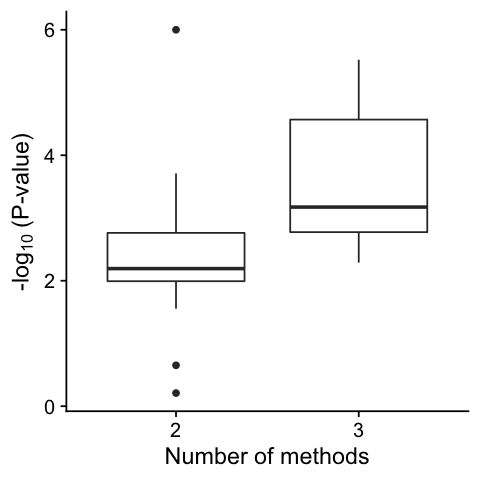

In [18]:
options(repr.plot.width=4, repr.plot.height=4)
as.tibble(consensus) %>%
    ggplot(aes(x = as.character(num_methods), y = -log10(p))) +
        geom_boxplot() +
        scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
        labs(x = 'Number of methods', y = bquote('-log'[10]~'(P-value)')) +
        theme(legend.position = 'bottom')

# Topology study

In [19]:
enrichment_test <- function(method, selected) {
    known_selected <- length(intersect(known_brca_genes, selected))
    known_not_selected <- length(setdiff(known_brca_genes, selected))
    unknown_selected <- length(intersect(vegas$Gene,selected)) - known_selected
    unknown_not_selected <- length(setdiff(vegas$Gene,selected)) - known_not_selected

    p <- fisher.test(matrix(c(known_selected,known_not_selected,
                              unknown_selected, unknown_not_selected),
                            nrow = 2), alternative = 'greater')$p.value %>% 
        format(digits = 2)
    
    tibble(method = method, p = p, 
           `BRCA selected`   = known_selected,
           `BRCA unselected` = known_not_selected,
           `Other selected`   = unknown_selected,
           `Other unselected`   = unknown_not_selected)
    
}

list(enrichment_test('dmGWAS', dmgwas), 
     enrichment_test('heinz', heinz),
     enrichment_test('LEAN', lean),
     enrichment_test('SConES GS', scones_gs),
     enrichment_test('SConES GM', scones_gm),
     enrichment_test('SConES GI', scones_gi),
     enrichment_test('SigMod', sigmod),
     enrichment_test('Consensus', names(V(consensus)))) %>%
    do.call(rbind,.)

method,p,BRCA selected,BRCA unselected,Other selected,Other unselected
<chr>,<chr>,<int>,<int>,<int>,<int>
dmGWAS,3.7e-05,7,146,187,32427
heinz,0.019,1,152,3,32611
LEAN,1,0,153,0,32614
SConES GS,0.0035,2,151,17,32597
SConES GM,0.03,2,151,56,32558
SConES GI,1,0,153,1,32613
SigMod,0.029,3,150,139,32475
Consensus,9.6e-05,4,149,47,32567


In [20]:
betweenness_test <- function(selected) {
    if (length(ppi_df$betweenness[ppi_df$name %in% selected])) {
        wilcox.test(ppi_df$betweenness[ppi_df$name %in% selected], 
                    ppi_df$betweenness[!ppi_df$name %in% selected],
                    alternative = 'greater')$p.value %>% 
        format(digits = 2)
    } else {
        NA
    }
}

list(tibble(method = 'dmGWAS', p = betweenness_test(dmgwas)),
     tibble(method = 'heinz', p = betweenness_test(heinz)),
     tibble(method = 'LEAN', p = betweenness_test(lean)),
     tibble(method = 'SConES GS', p = betweenness_test(scones_gs)),
     tibble(method = 'SConES GM', p = betweenness_test(scones_gm)),
     tibble(method = 'SConES GI', p = betweenness_test(scones_gi)),
     tibble(method = 'SigMod', p = betweenness_test(sigmod)),
     tibble(method = 'Consensus', p = betweenness_test(names(V(consensus))))) %>%
    do.call(rbind,.)

method,p
<chr>,<chr>
dmGWAS,6.9e-22
heinz,0.083
LEAN,NA
SConES GS,0.18
SConES GM,0.87
SConES GI,NA
SigMod,1e-24
Consensus,4.8e-14


In [21]:
topology <- ppi %>%
    mutate(in_consensus = name %in% unique(consensus_gg[['vertex.names']]),
           what = ifelse(in_consensus, 'Consensus', 'Rest'),
           what = ifelse(name %in% known_brca_genes, 'Known', what),
           what = ifelse(in_consensus & name %in% known_brca_genes, 'Consensus + known', what)) %>%
    as.tibble

In [22]:
# centrality DG vs non-DG
wilcox.test(topology$betweenness[topology$name %in% known_brca_genes],
            topology$betweenness[!topology$name %in% known_brca_genes],
            alternative = 'greater')


	Wilcoxon rank sum test with continuity correction

data:  topology$betweenness[topology$name %in% known_brca_genes] and topology$betweenness[!topology$name %in% known_brca_genes]
W = 1064290, p-value = 2.636e-05
alternative hypothesis: true location shift is greater than 0


In [23]:
# centrality consensus vs non-consensus
wilcox.test(topology$betweenness[topology$in_consensus & topology$name %in% known_brca_genes],
            topology$betweenness[topology$in_consensus & ! (topology$name %in% known_brca_genes)],
            alternative = 'greater')


	Wilcoxon rank sum test

data:  topology$betweenness[topology$in_consensus & topology$name %in%  and topology$betweenness[topology$in_consensus & !(topology$name %in%     known_brca_genes] and     known_brca_genes)]
W = 50, p-value = 0.939
alternative hypothesis: true location shift is greater than 0


Warning message:
“Removed 409 rows containing non-finite values (stat_boxplot).”

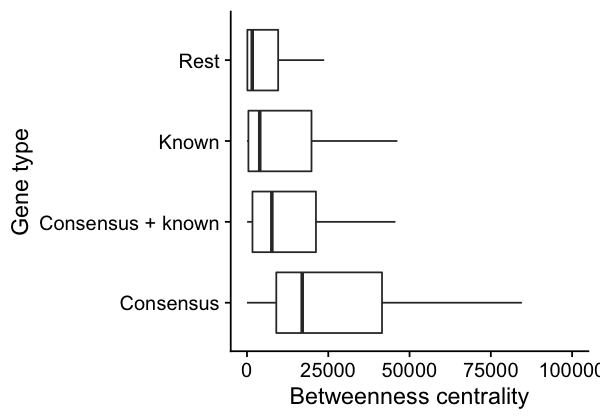

In [24]:
options(repr.plot.width=5, repr.plot.height=3.5)
topology %>%
    ggplot(aes(x = what, y = betweenness)) +
        geom_boxplot(outlier.colour = NA) +
        scale_y_continuous(limits = c(0, 1e+5)) +
        labs(x = 'Gene type', y = 'Betweenness centrality') +
        coord_flip()

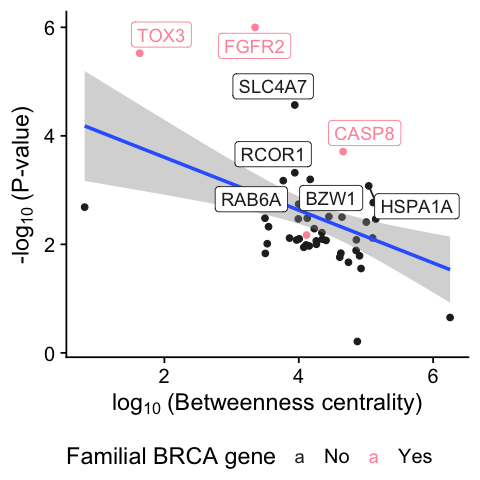

In [25]:
options(repr.plot.width=4, repr.plot.height=4)
filter(topology, grepl('Consensus', what)) %>%
    ggplot(aes(y = -log10(p), x = log10(betweenness))) +
        geom_point(aes(color = ifelse(what == 'Consensus + known', 'Yes', 'No'))) +
        geom_smooth(method = "glm") +
        geom_label_repel(data = filter(topology, grepl('Consensus', what) & p < .001), 
                         aes(label = name, color = ifelse(what == 'Consensus + known', 'Yes', 'No'))) +
        labs(x = bquote('log'[10]~'(Betweenness centrality)'), 
             y = bquote('-log'[10]~'(P-value)'), color = 'Familial BRCA gene') +
        theme(legend.position = 'bottom') +
        scale_color_manual(values = c('Yes' = '#ff96a7', 'No' = '#252525'))

In [26]:
cor(log10(topology$betweenness[grepl('Consensus', topology$what)]),
    -log10(topology$p[grepl('Consensus', topology$what)]))

[1] -0.4326907

In [27]:
clusters <- clusters(consensus)

# get largest component
clusters$csize

[1] 37  4  3  2  2  1  1  1

In [28]:
median_p <- lapply(seq(clusters$no), function(i){
    mean(vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == i]])
}) %>%
    do.call(c,.)

tibble(size = clusters$csize, median_p = median_p)

size,median_p
<dbl>,<dbl>
37,2.874172e-02
4,4.422207e-03
3,1.404986e-02
2,2.794972e-03
2,7.794922e-03
1,1.097999e-03
1,2.699997e-05
1,9.999990e-07


In [29]:
list(tibble(gene = names(clusters$membership)[clusters$membership == 8],
            p = vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == 8]]),
     tibble(gene = names(clusters$membership)[clusters$membership == 7],
            p = vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == 7]]),
     tibble(gene = names(clusters$membership)[clusters$membership == 6],
            p = vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == 6]])) %>%
    do.call(rbind,.)

gene,p
<chr>,<dbl>
FGFR2,9.999990e-07
SLC4A7,2.699997e-05
MRPS30,1.097999e-03


In [30]:
as_tibble(consensus) %>%
    arrange(-betweenness) %>%
    head

name,betweenness,degree,p,sigmod,dmgwas,heinz,scones_gm,known,num_methods
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
COPS5,1788165.0,673,0.222777223,TRUE,TRUE,FALSE,FALSE,FALSE,2
OFD1,374128.4,252,0.001679983,TRUE,TRUE,TRUE,FALSE,FALSE,3
HSPA1L,165093.5,127,0.001409986,TRUE,TRUE,FALSE,FALSE,FALSE,2
USHBP1,139624.2,125,0.003429966,TRUE,TRUE,FALSE,FALSE,FALSE,2
CRMP1,128148.8,95,0.001699983,TRUE,TRUE,FALSE,FALSE,FALSE,2
PRPF31,125508.3,111,0.007609924,TRUE,TRUE,FALSE,FALSE,FALSE,2


In [48]:
# COPS5 interrogation
filter(vegas, Gene %in% names(neighbors(consensus, 'COPS5'))) %>%
    filter(Gene != 'COPS5') %>%
    .$p %>%
    median

[1] 0.006089939

[1] "HSPA1A" "HSPA1A" "HSPA1B" "HSPA1B" "HSPA1L" "HSPA1L" "BLM"    "BLM"   
 [9] "KRT17"  "KRT17"  "AIMP1"  "AIMP1"  "RRP12"  "PRPF31" "PRPF31" "COPS5" 
[17] "COPS5"  "COPS5"  "COPS5"  "KRT16"  "KRT16"  "ABCF1"  "ABCF1"  "DAZAP1"
[25] "DAZAP1"

# Gene set enrichment analysis

## Consensus

In [31]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))

In [32]:
go_enrich <- enrichGO(gene    = names(clusters$membership)[clusters$membership == 1],
                      OrgDb   = org.Hs.eg.db,
                      keyType = 'SYMBOL') %>%
    as_tibble
go_enrich

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044183,protein binding involved in protein folding,2/37,14/16969,0.0004140872,0.02786285,0.02210642,HSPA1A/HSPA1B,2
GO:0051082,unfolded protein binding,3/37,83/16969,0.0007776062,0.02786285,0.02210642,HSPA1A/HSPA1B/HSPA1L,3
GO:0008266,poly(U) RNA binding,2/37,20/16969,0.0008574815,0.02786285,0.02210642,KHDRBS2/DAZAP1,2
GO:0070717,poly-purine tract binding,2/37,21/16969,0.0009464424,0.02786285,0.02210642,KHDRBS2/DAZAP1,2
GO:0008187,poly-pyrimidine tract binding,2/37,22/16969,0.0010396584,0.02786285,0.02210642,KHDRBS2/DAZAP1,2
GO:0031072,heat shock protein binding,3/37,108/16969,0.0016643662,0.03717085,0.02949140,HSPA1A/HSPA1B/HSPA1L,3


## SigMod

In [33]:
enrichGO(gene    = sigmod,
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as_tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005200,structural constituent of cytoskeleton,7/137,77/16969,2.879211e-06,0.0009098307,0.0008849785,KRT14/KRT19/TUBA3C/KRT15/KRT9/KRT17/KRT16,7


## dmGWAS

In [34]:
enrichGO(gene    = dmgwas,
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as_tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015631,tubulin binding,11/183,252/16969,9.371574e-05,0.03101991,0.02821337,OFD1/RAE1/SPAG5/CEP295/CCSER2/UXT/CENPE/IFT81/IFT74/BBS4/CAMSAP3,11
GO:0051082,unfolded protein binding,6/183,83/16969,2.749717e-04,0.04550782,0.04139048,AIP/HSPA1A/HSPA1B/HSPA1L/CCT7/PDRG1,6
